# Libraries

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from celluloid import Camera
from collections import defaultdict
from functools import partial
from tqdm import tqdm

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import ruptures as rpt

# Data

In [2]:
path_input  = os.path.join(os.path.dirname(os.getcwd()), 'data/input/')
path_output = os.path.join(os.path.dirname(os.getcwd()), 'data/output/')

In [3]:
### GENERATE DATA ###
# PATTERN ANOMALIES: SEASONAL DATA WITH TREND

np.random.seed(42)

n_series, timesteps = 3, 600

data = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                      process_noise=1, measure_noise=0)
seasons = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                            freq=24, measure_noise=4, level=0, amp=10)
data = data + seasons

In [4]:
start_time = pd.Timestamp.today()
timestamps = pd.date_range(start=start_time, periods=600, freq='30s')

In [5]:
ts_df = pd.DataFrame(data.T, index=timestamps, columns=['signalA', 'signalB', 'signalC'])

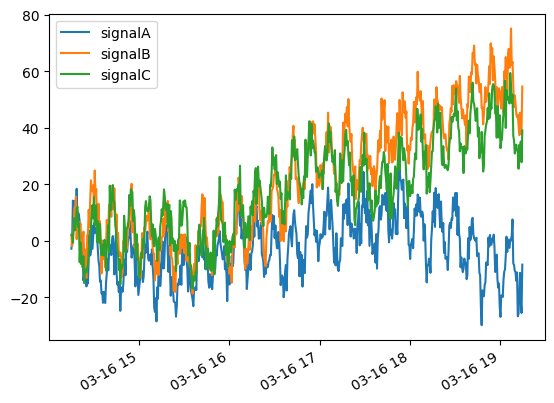

In [6]:
ts_df.plot()
plt.show()

# Estudio descriptivo

In [7]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression ='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print('##################')
    if (dftest[1]<0.05) and (dftest[0]<dftest[4]['5%']):
        print('Serie estacionaria')
    else:
        print('Serie no estacionaria')

In [8]:
test_stationarity(ts_df['signalA'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.104908
p-value                          0.928242
#Lags Used                      19.000000
Number of Observations Used    580.000000
Critical Value (1%)             -3.974464
Critical Value (5%)             -3.418087
Critical Value (10%)            -3.131520
dtype: float64
##################
Serie no estacionaria


## Descomposición de la serie

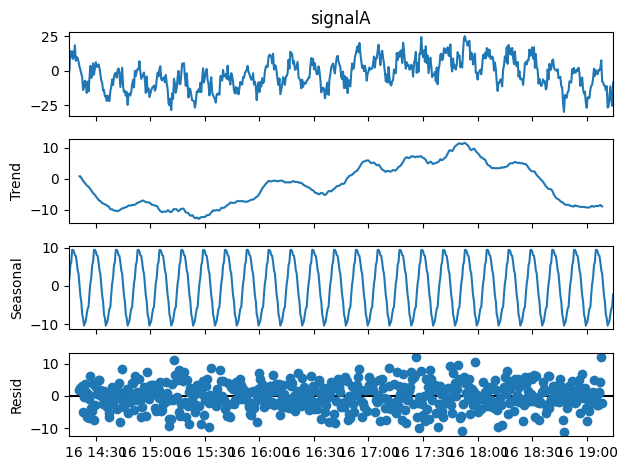

In [9]:
# Aplicar descomposición aditiva
ts_df_desc_Ad = seasonal_decompose(ts_df['signalA'], model='additive',period=24)
ts_df_desc_Ad.plot()
plt.show()

In [10]:
def seasonal_plot(df, season='year', index='month', column=None):
    """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
    Arguments:
    
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))

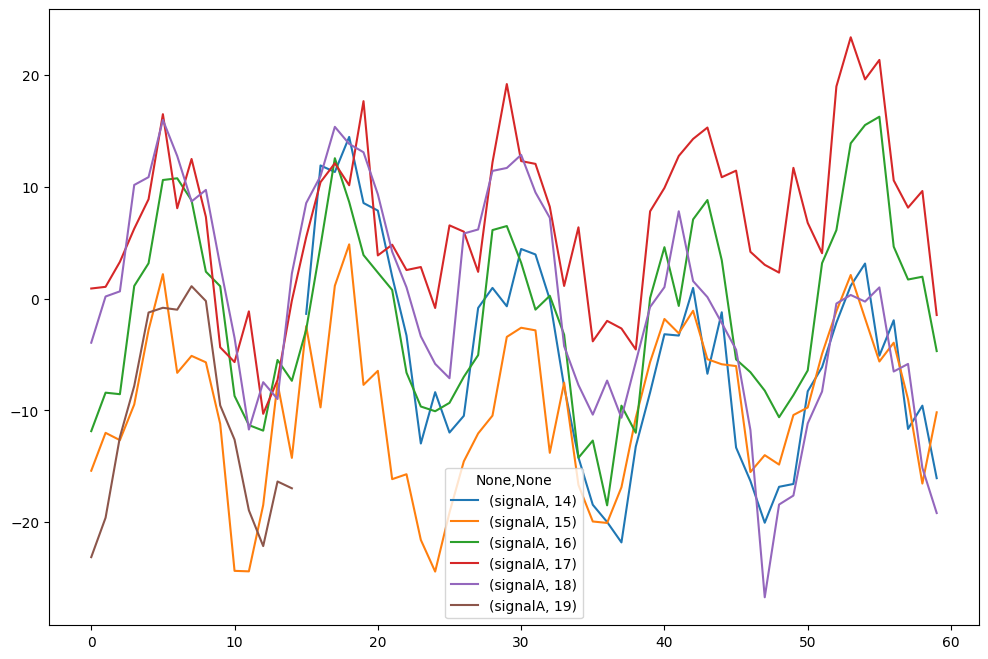

In [11]:
seasonal_plot(ts_df[['signalA']], season='hour', index='minute')
plt.show()

## Diferenciación regular

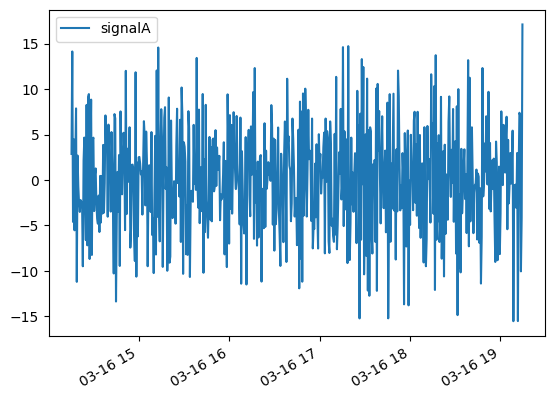

In [12]:
ts_df_diff_1 = ts_df[['signalA']].diff(periods=1)
ts_df_diff_1.plot()
plt.show()

## Diferenciación estacional

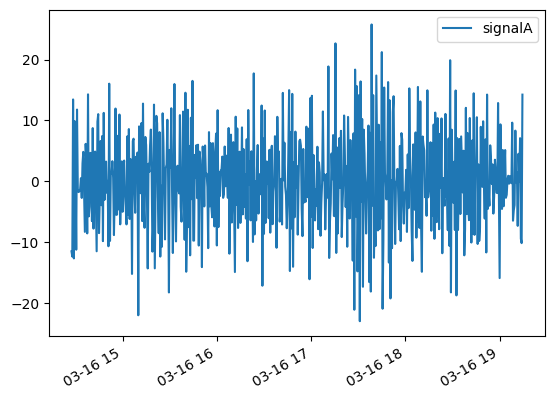

In [13]:
ts_df_diff_1_24 = ts_df_diff_1.diff(periods=24)
ts_df_diff_1_24.plot()
plt.show()

In [14]:
test_stationarity(ts_df_diff_1_24.dropna(inplace=False))


Results of Dickey-Fuller Test:
Test Statistic                -1.302510e+01
p-value                        1.262647e-20
#Lags Used                     8.000000e+00
Number of Observations Used    5.660000e+02
Critical Value (1%)           -3.974854e+00
Critical Value (5%)           -3.418275e+00
Critical Value (10%)          -3.131631e+00
dtype: float64
##################
Serie estacionaria


## Autocorrelación

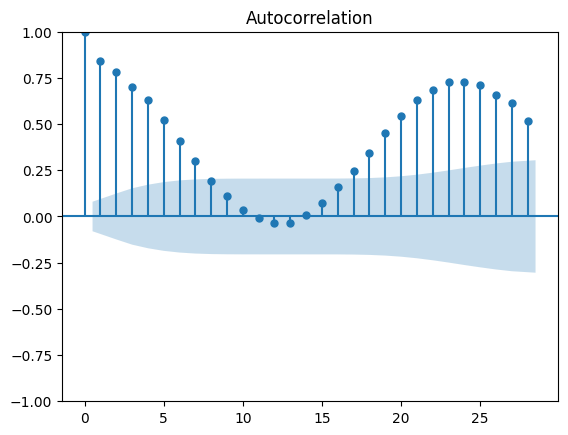

In [15]:
plot_acf(ts_df[['signalA']].dropna(inplace=False))
plt.show()

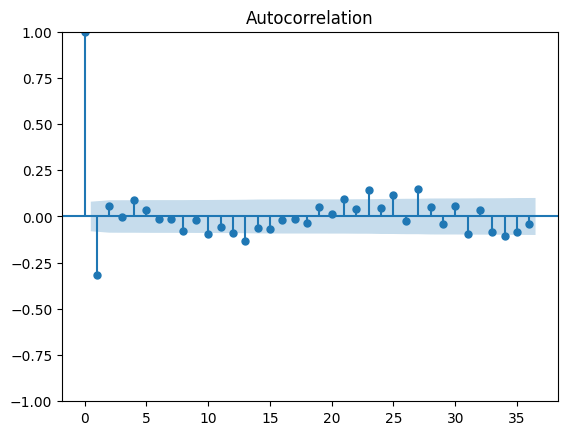

In [16]:
plot_acf(ts_df_diff_1.dropna(inplace=False),lags=36)
plt.show()

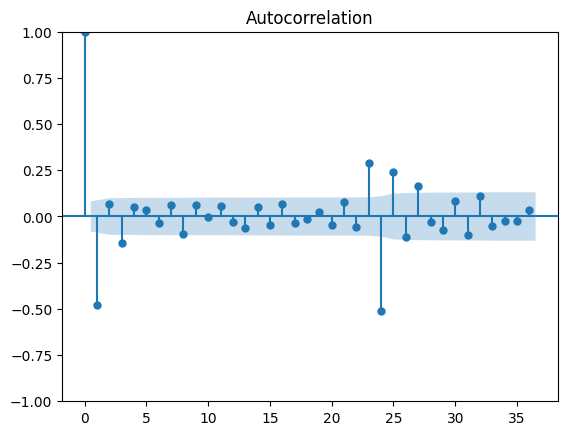

In [17]:
plot_acf(ts_df_diff_1_24.dropna(inplace=False), lags=36)
plt.show()

## Ruptures

In [18]:
# signal, bkps = rpt.pw_constant(n_samples=1000, n_features=1, n_bkps=4, noise_std=4, seed=42)
signal = ts_df['signalA'].values

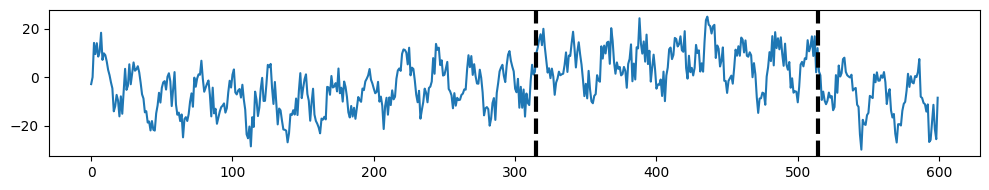

In [19]:
model = rpt.Pelt(model='rbf')
model.fit(signal)
result = model.predict(pen=10)
rpt.display(signal, [], result)
plt.show()

## Anomaly detection toolkit

In [20]:
from adtk.data import validate_series
from adtk.detector import ThresholdAD
from adtk.visualization import plot


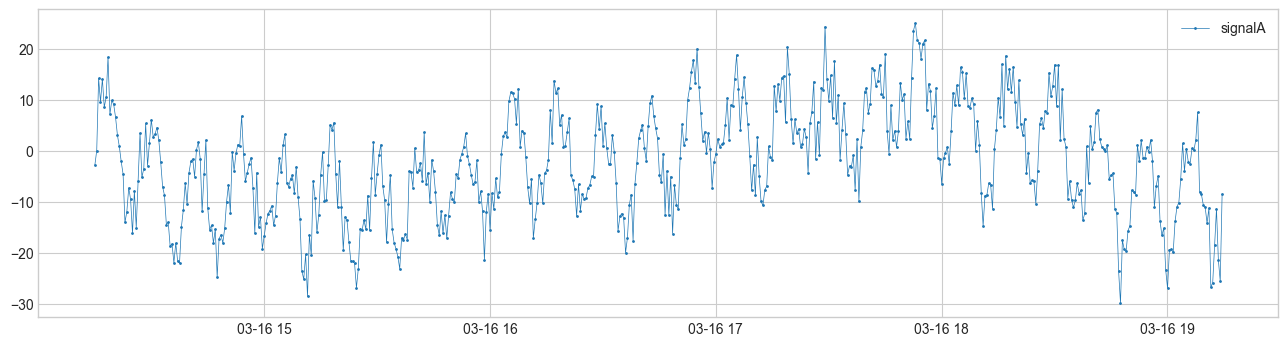

In [21]:
s_train = validate_series(ts_df[['signalA']])
plot(s_train)

plt.show()

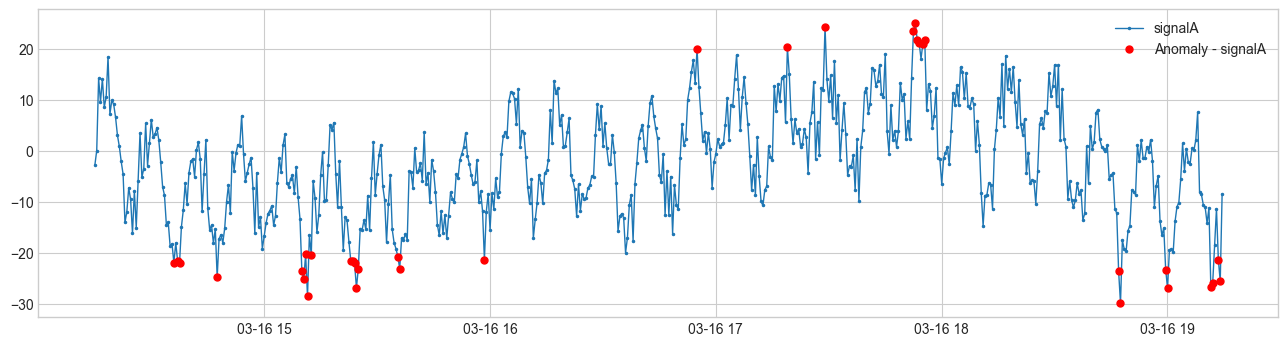

In [22]:
threshold_ad = ThresholdAD(high=20, low=-20)
anomalies = threshold_ad.detect(ts_df[['signalA']])
plot(ts_df[['signalA']], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag='marker')
plt.show()

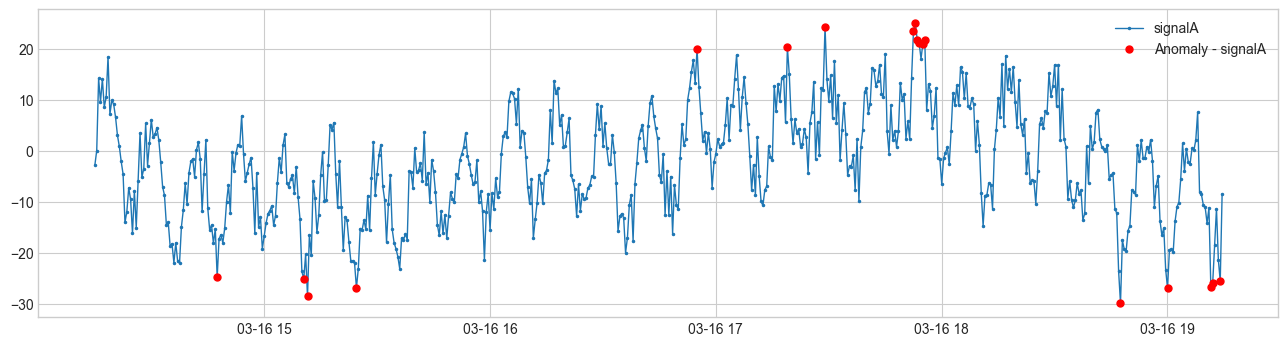

In [23]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1)
anomalies = iqr_ad.fit_detect(ts_df[['signalA']])
plot(ts_df[['signalA']], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag='marker')
plt.show()

## prophet 

In [24]:
from prophet import Prophet
from utils import prophet_fit, prophet_plot, get_outliers

c:\Users\jarl1\Git\GitHub\anomaly_detection\anom-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [25]:
df = ts_df[['signalA']].reset_index().rename(columns={'index':'ds', 'signalA':'y'})

In [26]:
prediction_size = 30
train_df_min = df[:-prediction_size]

In [27]:
q = Prophet(daily_seasonality=True)
q.fit(train_df_min)

future2 = q.make_future_dataframe(periods=60, freq='1min')
forecast2 = q.predict(future2)
forecast2.tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
625,2025-03-16 19:55:32.737952,-24.636270,-46.129096,-24.024686,-24.636276,-24.636262,-10.221076,-10.221076,-10.221076,-10.221076,-10.221076,-10.221076,0.0,0.0,0.0,-34.857346
626,2025-03-16 19:56:32.737952,-24.714805,-44.731260,-24.601898,-24.714811,-24.714797,-10.592981,-10.592981,-10.592981,-10.592981,-10.592981,-10.592981,0.0,0.0,0.0,-35.307786
627,2025-03-16 19:57:32.737952,-24.793340,-46.990100,-25.147926,-24.793347,-24.793332,-10.962920,-10.962920,-10.962920,-10.962920,-10.962920,-10.962920,0.0,0.0,0.0,-35.756260
628,2025-03-16 19:58:32.737952,-24.871875,-46.697978,-25.904011,-24.871882,-24.871867,-11.330798,-11.330798,-11.330798,-11.330798,-11.330798,-11.330798,0.0,0.0,0.0,-36.202673
629,2025-03-16 19:59:32.737952,-24.950410,-47.428568,-26.277645,-24.950418,-24.950402,-11.696523,-11.696523,-11.696523,-11.696523,-11.696523,-11.696523,0.0,0.0,0.0,-36.646933


c:\Users\jarl1\Git\GitHub\anomaly_detection\anom-venv\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jarl1\Git\GitHub\anomaly_detection\anom-venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


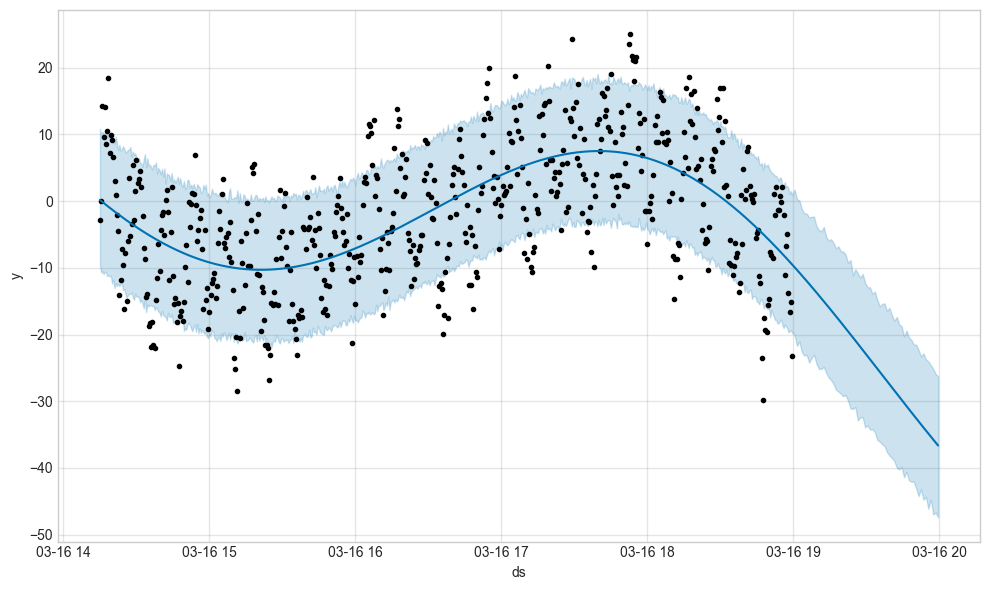

In [28]:
q.plot(forecast2)
plt.show()